In [1]:
from celmech.maps import CometMap
import rebound as rb
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import root_scalar

# set-up

In [2]:

wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi)-np.pi
def get_M(T,sim,wrap=True):
    sim.integrate(T)
    orbits = sim.calculate_orbits(primary=sim.calculate_com())
    if wrap:
        return wrap2pi(orbits[1].M)
    return orbits[1].M
def get_sos_data(sim,Npts):
    a,phi = np.zeros((2,Npts))
    ps = sim.particles
    P = ps[2].P
    for i in range(Npts):
        orbits = sim.calculate_orbits(primary=sim.calculate_com())
        a[i] = orbits[1].a
        try:
            rt = root_scalar(get_M,args=(sim),bracket=[sim.t+0.45*P,sim.t+0.55*P])
        except:
            P = ps[2].P
            rt = root_scalar(get_M,args=(sim),bracket=[sim.t+0.45*P,sim.t+0.55*P])
        orbits = sim.calculate_orbits(primary=sim.calculate_com())
        phi[i] = wrap2pi(orbits[0].l-orbits[1].l)
        rt = root_scalar(lambda T: get_M(T,sim,wrap=False) - np.pi ,bracket=[sim.t+0.45*P,sim.t+0.55*P])
    return a,phi


def get_sim(m_pert,n_pert,a_tp,l_pert,l_tp,q_tp,pomega_tp):
    sim = rb.Simulation()
    sim.add(m=1)
    P_pert = 2 * np.pi / n_pert
    sim.add(m=m_pert,P=P_pert,l=l_pert)
    sim.add(m=0.,a = a_tp,l=l_tp,e=1-q_tp/a_tp,pomega=pomega_tp)
    sim.move_to_com()
    return sim

def get_jacobi_const(sim):
    ps = sim.particles
    star = ps[0]
    planet = ps[1]
    particle = ps[2]
    rstar = np.array(star.xyz)
    rplanet = np.array(planet.xyz)
    r = np.array(particle.xyz)
    v = np.array(particle.vxyz)
    
    KE = 0.5 * v@v # test particle kinetic energy
    mu1 = sim.G * star.m
    mu2 = sim.G * planet.m
    r1 = r-rstar
    r2 = r-rplanet
    PE = -1*mu1/np.sqrt(r1@r1) - mu2/np.sqrt(r2@r2) # test particle potential energy
    
    lz = np.cross(r,v)[-1]
    
    CJ = 2 * planet.n * lz - 2 * (KE + PE) # jacobi constant
    return CJ
from scipy.optimize import root_scalar
def get_sim_at_fixed_CJ(a,CJ,q_bracket):
    get_sim_fn = lambda q,a: get_sim(m_pert,n_pert,a,l_pert,l_tp,q,pomega_tp)
    root_fn = lambda q,a: get_jacobi_const(get_sim_fn(q,a)) - CJ
    root = root_scalar(root_fn,args=(a,),bracket=q_bracket)
    assert root.converged, "Root-finding failed to converge for a={:.1f}, CJ={:.1f}".format(a,CJ)
    return get_sim_fn(root.root,a)

# Run map
System parameters

In [3]:
m_pert = 5.15e-5
n_pert = 1
l_pert = np.pi/2
pomega_tp =  np.pi
l_tp = pomega_tp + np.pi 
Nres = 20
q = 1.5 #44.1 / 30.06

Initialize map & reference simulation

In [5]:
from celmech.maps import CometMap
import warnings
cmap = CometMap(m_pert,Nres,q,max_kmax=32)
sim0=get_sim(m_pert,n_pert,Nres**(2/3),l_pert,l_tp,q,pomega_tp)
CJ0 = get_jacobi_const(sim0)

Initiliaze rebound sims for various semi-major axes

In [6]:
a0s = (Nres*(1+np.linspace(0,.02,2*16)))**(2/3) 
sims = []
for a0 in a0s:
    sims.append(get_sim_at_fixed_CJ(a0,CJ0,[q*0.9,q*1.2]))
try:
    data = np.load("./all_sos_pts.npy")
except:    
    all_sos_pts = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i,sim in enumerate(sims):
            all_sos_pts.append(get_sos_data(sim,200))
    data = np.array(all_sos_pts)
    np.save("./all_sos_pts",data)

In [7]:
def get_map_pts(X0,cm,N):
    pts = np.zeros((N,2))
    for i in range(N):
        pts[i] = X0
        X0 = cm(X0)
    return pts

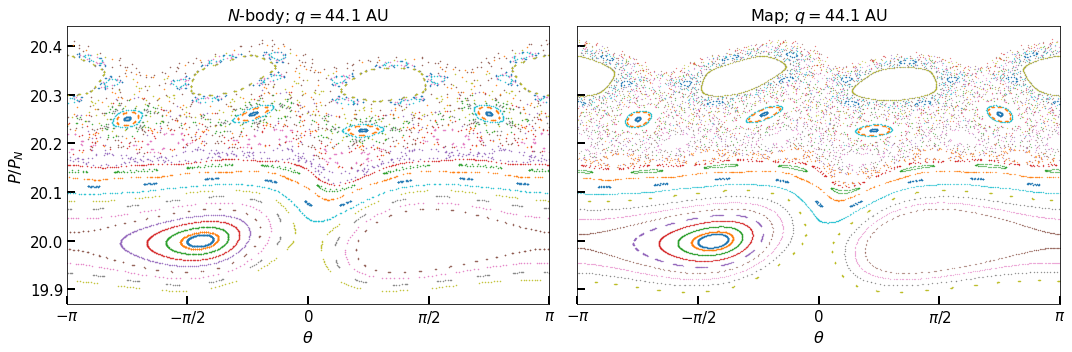

In [8]:
fig,ax=plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,5))

wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi) - np.pi
for y,x in data:
    l,=ax[0].plot(x,y**(1.5),'.',ms=1)
    pts = get_map_pts((x[0],y[0]**(1.5) - cmap.N),cmap,500)
    phi = wrap2pi(pts[:,0])
    x = pts[:,1]
    ax[1].plot(phi,cmap.N+x,'.',ms=0.5,color=l.get_color())

for a in ax:
    a.set_xlim(-np.pi,np.pi)
    a.set_xticks([-np.pi,-0.5*np.pi,0,0.5*np.pi,np.pi])
    a.set_xticklabels(["$-\pi$","$-\pi/2$","$0$","$\pi/2$","$\pi$"],fontsize=15)
    a.set_xlabel(r"$\theta$",fontsize=16)
    xax=a.xaxis
    xax.set_tick_params(direction='in',width=2,size=8)
    yax= a.yaxis
    yax.set_tick_params(direction='in',width=2,size=8,labelsize=15)
plt.subplots_adjust(wspace=0.05)
ax[0].set_title("$N$-body; $q=44.1$ AU",fontsize=16)
ax[1].set_title("Map; $q=44.1$ AU",fontsize=16)
ax[0].set_title("$N$-body; $q=44.1$ AU",fontsize=16)
ax[0].set_ylabel("$P/P_N$",fontsize=16)
plt.tight_layout()
#plt.savefig("../figures/comet_nbody_vs_map.png")

# Predict separatrix

In [9]:
cmap.m = 1e-5
Nres=1

In [10]:
all_pts_map = []
x0s = 1/Nres + np.linspace(-0.03,0.03,30)
for x0 in x0s:
    pts = get_map_pts((np.random.uniform(-np.pi,np.pi),x0),cmap,500)
    phi = wrap2pi(pts[:,0])
    x = pts[:,1]
    all_pts_map.append((phi,x))
    

In [11]:

Hfn = lambda q,p: 0.5 * (p-1/Nres)**2  + (0.5*cmap.eps/np.pi) * np.sum([amp * np.cos((k+1)*q) / (k+1)  for k,amp in enumerate(cmap.amps) if (k+1)%Nres==0])
Ngrid = 200
qq = np.linspace(-np.pi,np.pi,Ngrid)
pp = 1/Nres*(1 + np.linspace(-0.06,0.06,Ngrid))
X,Y = np.meshgrid(qq,pp)
Z = np.vectorize(Hfn)(X,Y)

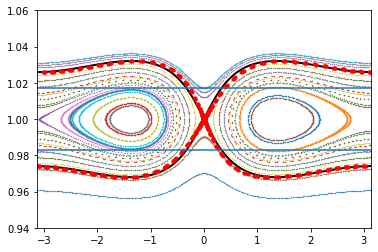

In [12]:
wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi) - np.pi
for phi,x in all_pts_map:
    plt.plot(phi[:-1],0.5 * (x[1:] + x[:-1]),'.',ms=0.5)
plt.contour(X,Y,Z,colors=['black'],levels=[Hfn(0,1/Nres)],linewidths=[2])
pts = get_map_pts((-0.01,1/Nres),cmap,500)
plt.plot(wrap2pi(pts.T[0]),pts.T[1],'r.')

half_width =  np.sqrt(2 * cmap.eps * (cmap.amps[Nres-1]/Nres) / np.pi)
plt.axhline(1/Nres + half_width)
plt.axhline(1/Nres - half_width)

Res overlap criterion

In [29]:
from sympy import totient
# def asdf(cmap):
#     vals = []
#     for k_minus_one,amp in enumerate(cmap.amps):
#         k=k_minus_one+1
#         if k==1:
#             ck = cmap.amps[1]/k
#         else:
#             ck = amp/k
#         half_width = np.sqrt(2 * ck / np.pi)
#         vals.append(2 * totient(k) * half_width)
#     return np.array(vals)
def get_eps_crit(cmap):
    tot = 0
    for k_minus_one,amp in enumerate(cmap.amps):
        k=k_minus_one+1
        if k==1:
            ck = cmap.amps[1]/k
        else:
            ck = amp/k
        half_width = np.sqrt(2 * ck / np.pi)
        tot += 2 * totient(k) * half_width
    return 1/tot/tot
def get_eps_crit(cmap):
    tot = 0
    for k_minus_one,amp in enumerate(cmap.amps):
        k=k_minus_one+1
        if k==1:
            ck = cmap.amps[1]/k
        else:
            ck = amp/k
        half_width = 2 * np.sqrt(3 * ck / np.pi / 3)
        tot += 2 * totient(k) * half_width
    return 1/tot/tot

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cmap.q = 35/30
    cmap.kmax = 32
    crit1 = get_eps_crit(cmap)
    cmap.kmax = 2*32
    crit2 = get_eps_crit(cmap)
    print((crit2 - crit1)/crit2)


-0.3564431991724692


In [31]:
qvals = np.linspace(40/30,2.2,10)
eps_crits = np.zeros(len(qvals))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cmap._kmax = 32
    for i,q in enumerate(qvals):
        if q>1.8:
            cmap._kmax = 12
        cmap.q = q
        eps_crit = get_eps_crit(cmap)
        eps_crits[i] = eps_crit

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cmap._kmax = 32
    cmap.q = 4/3

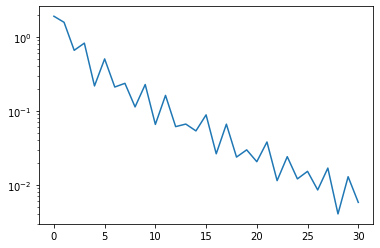

In [33]:
eps_crit_vs_kmax = 1/(np.cumsum(asdf(cmap)))**2
plt.plot(np.abs((eps_crit_vs_kmax[1:]-eps_crit_vs_kmax[:-1])/eps_crit_vs_kmax[1:]))
plt.yscale('log')

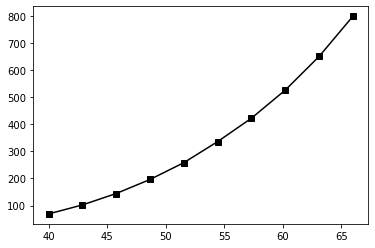

In [34]:
acrit = 30 * (eps_crits/5.15e-5)**(2/5) 
plt.plot(qvals * (30),acrit ,'ks-')



In [35]:
np.save("./neptune_overlap_pts_corrected",np.vstack((qvals * (30),acrit)))

In [19]:
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=5.15e-5,a=30,l=0)
sim.add(m=0,a=200,e=1-40/200,pomega=0,l=np.pi)
sim.move_to_com()
sim.integrator='whfast'
set_time_step(sim,1/22.)
interval = int(20*sim.particles[-1].P//sim.dt) * sim.dt
sim.automateSimulationArchive('runme.sa',interval=interval,deletefile=True)
sim.integrate(1000 * interval)

results = get_simarchive_integration_results('runme.sa')

plt.plot(results['time']/sim.particles[1].P,results['a'][1])

NameError: name 'set_time_step' is not defined

# N-body test comparison

In [7]:
from celmech.nbody_simulation_utilities import set_time_step, get_simarchive_integration_results

In [8]:
if False:
    sim = rb.Simulation()
    sim.add(m=1)
    sim.add(m=5.15e-5,a=1)
    for I,q0 in enumerate(qvals):
        for J,f in enumerate(np.geomspace(0.9,2,10)):
            a0 = ((f*eps_crits/5.15e-5)**(2/5))[I]
            sim.add(m=0,a=a0,e = 1 - q0/a0,l='uniform',pomega='uniform',hash='tp_{}_{}'.format(I,J))
    sim.move_to_com()
    sim.integrator='whfast'
    set_time_step(sim,1/22.)
    interval = int(20*sim.particles[-1].P//sim.dt) * sim.dt
    sim.automateSimulationArchive('all.sa',interval=interval,deletefile=True)
    sim.integrate(512 * interval)

# map plot

(0.0, 1.0)

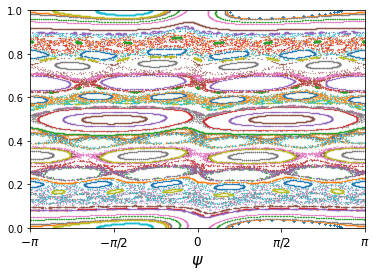

In [20]:
cmap.m = 4 * (get_eps_crit(cmap)/cmap.eps) * cmap.m

wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi) - np.pi
wrap1 = lambda x: np.mod(x,1)
for x0 in np.linspace(0,1):
    pts = get_map_pts((np.random.uniform(-np.pi,np.pi),x0),cmap,1500)
    phi = wrap2pi(pts[:,0])
    x = pts[:,1]
    plt.plot(phi,wrap1(x),'.',ms=0.5)
a = plt.gca()
a.set_xlim(-np.pi,np.pi)
a.set_xticks([-np.pi,-0.5*np.pi,0,0.5*np.pi,np.pi])
a.set_xticklabels(["$-\pi$","$-\pi/2$","$0$","$\pi/2$","$\pi$"],fontsize=12)
a.set_xlabel("$\psi$",fontsize=16)
a.set_ylim(0,1)

# Diffusion 

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size']=16
rcParams['axes.linewidth'] = 2
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['xtick.major.size'] = 8
rcParams['ytick.major.size'] = 8

rcParams['xtick.minor.size'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1.5
rcParams['ytick.minor.width'] = 1.5


rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [10]:
eps_vals = np.geomspace(0.1,20,100)
for eps in eps_vals:
    cmap.m=(eps/cmap.eps) * cmap.m

In [11]:
cmap.kmax=30

/Users/shadden/Projects/celmech/celmech/miscellaneous.py:659: LinAlgWarning: Ill-conditioned matrix (rcond=2.07491e-17): result may not be accurate.
  Fsoln = linsolve(D + f*A_tr_mtrx,f*np.reshape(fvec_fn(xj),-1))
/Users/shadden/Projects/celmech/celmech/miscellaneous.py:659: LinAlgWarning: Ill-conditioned matrix (rcond=6.99892e-18): result may not be accurate.
  Fsoln = linsolve(D + f*A_tr_mtrx,f*np.reshape(fvec_fn(xj),-1))
/Users/shadden/Projects/celmech/celmech/miscellaneous.py:659: LinAlgWarning: Ill-conditioned matrix (rcond=8.12568e-18): result may not be accurate.
  Fsoln = linsolve(D + f*A_tr_mtrx,f*np.reshape(fvec_fn(xj),-1))
/Users/shadden/Projects/celmech/celmech/miscellaneous.py:659: LinAlgWarning: Ill-conditioned matrix (rcond=8.9305e-18): result may not be accurate.
  Fsoln = linsolve(D + f*A_tr_mtrx,f*np.reshape(fvec_fn(xj),-1))
/Users/shadden/Projects/celmech/celmech/miscellaneous.py:659: LinAlgWarning: Ill-conditioned matrix (rcond=3.01382e-18): result may not be accura

In [2]:
import numpy as np

In [ ]:
np.polyfit()

In [12]:
D_QL = dict()
D_num = dict()
for q in [35,40,45,50]:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cmap.q = q/30
    xunst = np.array((0,0.5))
    cmap.mod = False
    Niter = 800
    Npts = 200
    DF_rates = []
    eps_vals = np.geomspace(0.01,35,100)
    for eps in eps_vals:
        cmap.m = (eps/cmap.eps) * cmap.m
        dpts = np.zeros((Npts,2))
        dpts[:,1] = np.random.normal(0,1e-8,size=Npts)
        pts = xunst + dpts
        sigma = np.zeros(Niter)
        for i in range(Niter):
            #all_pts
            sigma[i] = np.sqrt(np.var(pts[:,1]))
            pts=np.transpose(cmap(pts.T))
        X = sigma**2/np.arange(1,Niter+1)
        DF_rates.append(np.mean(X[400:]))
    ck = cmap.amps/np.arange(1,cmap.kmax+1)
    ck[0] = cmap.amps[0]
    D_QL[q] = 0.5 * (eps_vals)**2 * (cmap.amps @ cmap.amps) 
    D_num[q] = DF_rates

fig = plt.figure(figsize=(9,6))
mNep = 5.15e-5
sma = 30 * (0.75 * eps_vals / mNep)**(2/5)
for q in D_num.keys():
    plt.plot(sma,D_num[q]/D_QL[q],'s',label=f"{q:d}")

plt.plot(sma,sigmoid(np.log(sma/200)))
plt.xscale('log')

plt.legend(title=r"$q$ [AU]",loc='lower right')
plt.xlim(np.min(sma),5e3)
plt.xscale('log')
xts=[300,500,1000,3000]
plt.xticks(xts,["{}".format(xt) for xt in xts])
# plt.yscale('log')
plt.xlabel(r"$a$ [AU]",fontsize=20)
plt.ylabel(r"$D/D_\mathrm{QL}$",fontsize=20)
plt.axhline(1,ls='--',color='k')
plt.ylim(0,2)
plt.tight_layout()
#plt.savefig("../figures/comet_map_diffusion_compare.png")

In [18]:
sma[0]

220.00009505138982

In [23]:
(D_num[35]/D_QL[35])[0]

0.5372446792681723

In [24]:
sigmoid = lambda x: 0.5 * (1 + np.tanh(x))

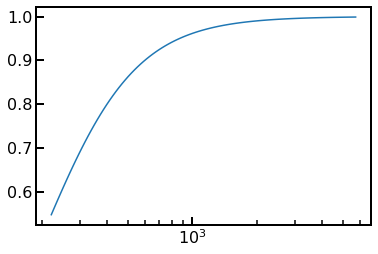

In [25]:
plt.plot(sma,sigma(np.log(sma/200)))

TypeError: 'numpy.ndarray' object is not callable

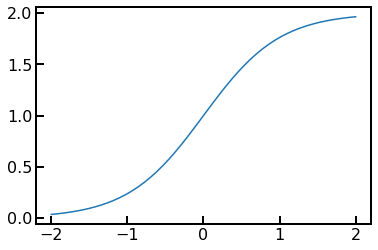

In [22]:
plt.plot(np.linspace(-2,2),1 + np.tanh(np.linspace(-2,2)))

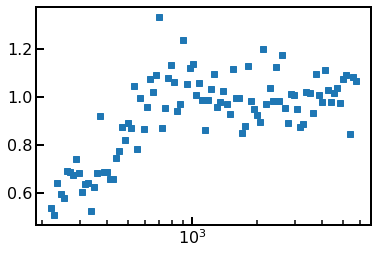

In [16]:
plt.plot(sma,D_num[35]/D_QL[35],'s',label=f"{q:d}")
plt.plot(sma,(D_num[35]/D_QL[35])[0],'s',label=f"{q:d}")
plt.xscale('log')

# Is it Markov?

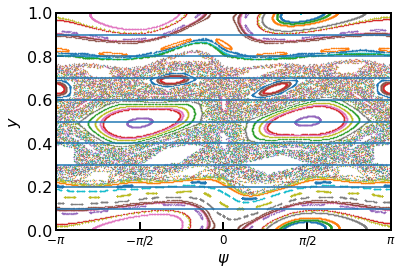

In [104]:
cmap.m = 3 * (get_eps_crit(cmap)/cmap.eps) * cmap.m
wrap2pi = lambda x: np.mod(x+np.pi,2*np.pi) - np.pi
wrap1 = lambda x: np.mod(x,1)
for x0 in np.linspace(0,1):
    pts = get_map_pts((np.random.uniform(-np.pi,np.pi),x0),cmap,1500)
    phi = wrap2pi(pts[:,0])
    x = pts[:,1]
    plt.plot(phi,wrap1(x),'.',ms=0.5)
a = plt.gca()
a.set_xlim(-np.pi,np.pi)
a.set_xticks([-np.pi,-0.5*np.pi,0,0.5*np.pi,np.pi])
a.set_xticklabels(["$-\pi$","$-\pi/2$","$0$","$\pi/2$","$\pi$"],fontsize=12)
a.set_xlabel("$\psi$",fontsize=16)
a.set_ylabel("$y$",fontsize=16)
a.set_ylim(0,1)
ybins = np.linspace(0,1,Nbins+1)
ybins = np.array(list(zip(ybins[:-1],ybins[1:])))
for yb in ybins:
    plt.axhline(yb[0])

In [35]:

ybins = np.array(list(zip(ybins[:-1],ybins[1:])))

In [36]:
def itermap(m,N,x0):
    for _ in range(N):
        x0=m(x0)
    return x0

Transition matrix:
$$T_{ij}(\tau) =  P(y\in b_j,\tau | y \in b_i)$$
where the $i$th bin is $b_i = [y_i,y_{i+1})$

Text(0.5, 0, '$b_j$')

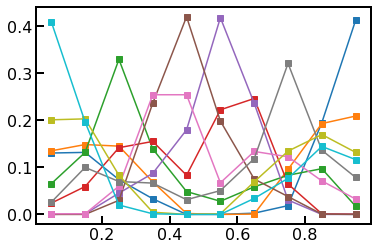

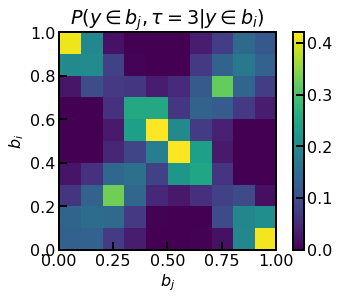

In [92]:
Nbins = 10
transition_matrix = np.zeros((Nbins,Nbins))
ybins = np.linspace(0,1,Nbins+1)
N = 1500
tau = 3
for i in range(Nbins):
    ylo,yhi = ybins[i],ybins[i+1]
    y0s = np.random.uniform(ylo,yhi,N)
    phi0s = np.random.uniform(-np.pi,np.pi,N)
    inits=np.transpose((phi0s,y0s))
    finals = np.array([itermap(cmap,tau,x0) for x0 in inits])
    yfs = wrap1(finals[:,1])
    counts,edges = np.histogram(yfs, bins=ybins)
    transition_matrix[i] = counts/N
    plt.plot(0.5 * (edges[1:]+edges[:-1]),counts/N,'s-')

plt.figure()
plt.imshow(transition_matrix,extent=[0,1,0,1],origin='lower')
plt.colorbar()
plt.title(r"$ P(y\in b_j,\tau=3| y \in b_i)$")
plt.ylabel("$b_i$")
plt.xlabel("$b_j$")

Text(0.5, 0, '$b_j$')

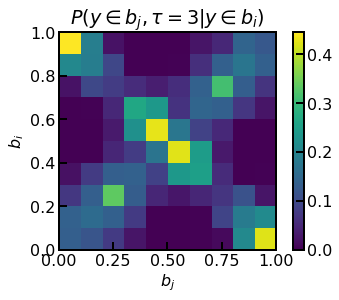

In [91]:
plt.figure()
plt.imshow(transition_matrix,extent=[0,1,0,1],origin='lower')
plt.colorbar()
plt.title(r"$ P(y\in b_j,\tau=3| y \in b_i)$")
plt.ylabel("$b_i$")
plt.xlabel("$b_j$")

Text(0.5, 0, '$b_j$')

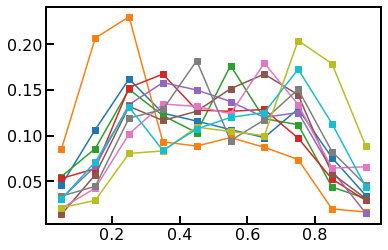

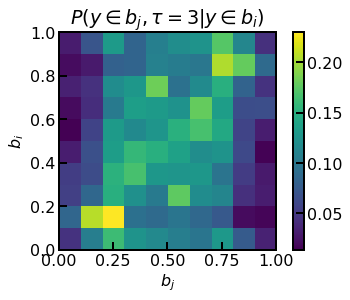

In [95]:
Nbins = 10
transition_matrix = np.zeros((Nbins,Nbins))
ybins = np.linspace(0,1,Nbins+1)
N = 1500
tau = 15
for i in range(Nbins):
    ylo,yhi = ybins[i],ybins[i+1]
    y0s = np.random.uniform(ylo,yhi,N)
    phi0s = np.random.uniform(-0.1,0.1,N)
    inits=np.transpose((phi0s,y0s))
    finals = np.array([itermap(cmap,tau,x0) for x0 in inits])
    yfs = wrap1(finals[:,1])
    counts,edges = np.histogram(yfs, bins=ybins)
    transition_matrix[i] = counts/N
    plt.plot(0.5 * (edges[1:]+edges[:-1]),counts/N,'s-')

plt.figure()
plt.imshow(transition_matrix,extent=[0,1,0,1],origin='lower')
plt.colorbar()
plt.title(r"$ P(y\in b_j,\tau=3| y \in b_i)$")
plt.ylabel("$b_i$")
plt.xlabel("$b_j$")